In [1]:
import keras 
from keras.layers import LSTM,Dense,Conv1D,MaxPooling1D
from keras.models import Sequential,Model
from gensim.models import Word2Vec
from keras.layers import Bidirectional,TimeDistributed
import numpy as np
import codecs
import regex
import  matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
data_div=1
sent=[]
tags=[]
with codecs.open("v1_train.ta","r",encoding="utf-8") as f:
    l1=[]
    l2=[]
    for i in f:
        x=i.split()
        if(x[0]=="newline"):
            sent.append(l1)
            tags.append(l2)
            l1=[]
            l2=[]
        else:
            l1.append(x[0])
            l2.append(x[1])

In [3]:
print(len(sent))
tag_count=0
for i in tags:
    for j in i:
        if(j!="other"):
            tag_count+=1
print(tag_count)
tag_map={'datenum': 0,
 'event': 0,
 'location': 0,
 'name': 0,
 'number': 0,
 'occupation': 0,
 'organization': 0,
 'other': 0,
 'things': 0}
for i in tags:
    for j in i:
        tag_map[j]+=1
print(tag_map)
print()

134030
382876
{'location': 134262, 'things': 6183, 'datenum': 15482, 'other': 1109354, 'occupation': 16507, 'event': 5112, 'number': 77310, 'name': 118021, 'organization': 9999}



In [4]:
from sklearn.model_selection import train_test_split
sent,pre_x_test,tags,pre_y_test=train_test_split(sent,tags,test_size=0.1,random_state=1)
print(len(sent))
print(len(tags))
print(len(pre_x_test))
print(len(pre_y_test))

120627
120627
13403
13403


0 : 13944
1 : 18442
2 : 28607
3 : 24909
4 : 12169
5 : 11453
6 : 3890
7 : 2432
8 : 1579
9 : 1272
10 : 665
11 : 416
12 : 247
13 : 170
14 : 125
15 : 87
16 : 61
17 : 45
18 : 29
19 : 21
20 : 15
21 : 10
22 : 3
23 : 7
24 : 4
25 : 5
26 : 1
27 : 3
28 : 2
29 : 1
30 : 2
31 : 3
33 : 2
34 : 2
35 : 1
37 : 1
38 : 1
39 : 1


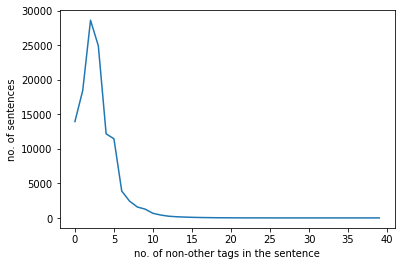

In [5]:
def get_data_distribution(sent,tags):
    cnt_dict={}
    for i in tags:
        cnt=0
        for j in i:
            if(j!="other"):
                cnt+=1
        if(cnt in cnt_dict):
            cnt_dict[cnt]+=1
        else:
            cnt_dict[cnt]=1
    cnt_list=list(cnt_dict.keys())
    cnt_list.sort()
    l1=[]
    l2=[]
    for i in cnt_list:
        print(i,":",cnt_dict[i])
        l1.append(i)
        l2.append(cnt_dict[i])
    plt.plot(l1,l2)
    plt.xlabel("no. of non-other tags in the sentence")
    plt.ylabel("no. of sentences")
    plt.show()
get_data_distribution(sent,tags)

In [6]:
def filter_data(sent,tags,exclude_list):
    sent_filter=[]
    tags_filter=[]
    for i in range(len(tags)):
    #     print(tags[i])
        cnt=0
        for j in tags[i]:
            if(j!="other"):
                cnt+=1
        if(cnt in exclude_list):
            continue
        if(cnt>=0):
            sent_filter.append(sent[i])
            tags_filter.append(tags[i])
    return sent_filter,tags_filter
sent_filter,tags_filter=filter_data(sent,tags,[])
print(len(sent_filter))
print(len(tags_filter))

120627
120627


In [7]:
sent=sent_filter
tags=tags_filter
def divide_data_pactise(sent,tags,data_div):
    print("initial_len=",len(sent))
    sent=sent[:len(sent)//data_div]
    tags=tags[:len(tags)//data_div]
    return sent,tags
sent,tags=divide_data_pactise(sent,tags,data_div)
print("new_len=",len(sent))

initial_len= 120627
new_len= 120627


In [8]:
for i in sent[:10]:
    print(i)

['கவனமாகக்', 'காய்ச்சி', 'குளிரவைக்கும்', 'போது', 'ஒற்றைச்சரிவு', 'படிகம்', 'உற்பத்தியாகி', 'காலியிடங்களை', 'நிரப்புகிறது']
['எனினும்', 'இம்மொழிகளில்', 'பல', 'பிரெஞ்சு', 'மொழியின்', 'தாக்கத்தால்', 'வழக்கொழிந்து', 'போயுள்ளன']
['இது', 'ஐதராபாத்தின்', 'கிழக்குப்', 'புறநகர்ப்', 'பகுதியான', 'உப்பாலில்', 'அமைந்துள்ளது']
['மந்தியூர்', 'ஊராட்சி', ',', 'தமிழ்நாட்டின்', 'திருநெல்வேலி', 'மாவட்டத்தில்', 'உள்ள', 'கடையம்', 'வட்டாரத்தில்', 'அமைந்துள்ளது']
['இவர்களில்', 'பெண்கள்', '1492', 'பேரும்', 'ஆண்கள்', '1538', 'பேரும்', 'உள்ளனர்']
['இதன்', 'இசையமைப்பாளர்', 'மகேஷ்', 'மாதவன்']
['இவர்', 'நடித்த', 'திரைப்படங்களில்', 'கன்னட', 'மொழித்', 'திரைப்படங்களே', 'அதிகமாகும்']
['ரெட்பஸ்', 'இன்', 'ஆங்கிலம்']
['இவற்றில்', 'இருந்து', '7', 'ஊராட்சி', 'மன்ற', 'உறுப்பினர்களைத்', 'தேர்ந்தெடுக்கின்றனர்']
['திண்டுக்கல்', 'வரை', 'தெற்கு', 'தொடர்வண்டிப்', 'பாதையும்', 'இந்த', 'நெடுஞ்சாலைக்கு', 'இணையாக', 'அமைந்துள்ளது']


In [9]:
max_sent_len=-1
for i in sent:
    if(len(i)>max_sent_len):
        max_sent_len=len(i)
print("max_sent_len",max_sent_len)
avg_sent_len=0
for i in sent:
    avg_sent_len+=len(i)
avg_sent_len=avg_sent_len/len(sent)
print("avg_sent_len",avg_sent_len)
max_len=int(2*(avg_sent_len))
print("max_sent_len_fit",max_len)

max_sent_len 210
avg_sent_len 11.138260920026196
max_sent_len_fit 22


In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.sequence import pad_sequences

In [11]:
# regex.findall(r'\X', sent[0][0])
def separate_into_char(sent):
    char=[]
    for i in sent:
        for j in i:
            l=regex.findall(r'\X',j)
            char.append(l)
    return char
char=separate_into_char(sent)

In [12]:

for i in char[:10]:
    print(i)


['க', 'வ', 'ன', 'மா', 'க', 'க்']
['கா', 'ய்', 'ச்', 'சி']
['கு', 'ளி', 'ர', 'வை', 'க்', 'கு', 'ம்']
['போ', 'து']
['ஒ', 'ற்', 'றை', 'ச்', 'ச', 'ரி', 'வு']
['ப', 'டி', 'க', 'ம்']
['உ', 'ற்', 'ப', 'த்', 'தி', 'யா', 'கி']
['கா', 'லி', 'யி', 'ட', 'ங்', 'க', 'ளை']
['நி', 'ர', 'ப்', 'பு', 'கி', 'ற', 'து']
['எ', 'னி', 'னு', 'ம்']


In [13]:
char_embedding_size=50
word_min_count=1
c2v=Word2Vec(char,size=char_embedding_size,min_count=word_min_count)
# print(c2v.wv["ल"])
# c2v.wv.most_similar(positive="ा")

In [14]:
# c2v.wv.most_similar(positive="क")
len(c2v.wv.vocab)

3195

In [15]:
tokenizer_char=Tokenizer()
tokenizer_char.fit_on_texts(char)
char_index=tokenizer_char.word_index
print(len(char_index))
num_char=(len(char_index)*3)//4
print(num_char)

3195
2396


In [16]:
def add_unk_char(char_index,num_char):
    ref={}
    for i,j in char_index.items():
        if(j<=num_char):
            ref[i]=j
    ref["<UNK_CHAR>"]=num_char+1
    char_index=ref
    char_index_rev={}
    for (i,j) in char_index.items():
        char_index_rev[j]=i
    print(char_index["<UNK_CHAR>"])
    print(char_index_rev[char_index["<UNK_CHAR>"]])
    return char_index,char_index_rev
char_index,char_index_rev=add_unk_char(char_index,num_char)

2397
<UNK_CHAR>


In [17]:
print("No. of chars:",len(char_index))

No. of chars: 2397


In [18]:
max_char_len=-1
for i in char:
    if(len(i)>max_char_len):
        max_char_len=len(i)
print(max_char_len)
avg_char_len=0
for i in char:
    avg_char_len+=len(i)
avg_char_len=avg_char_len/len(char)
print(avg_char_len)
max_char_len=int(2*avg_char_len)
print("max_char_len_fit",max_char_len)

106
4.485572446644214
max_char_len_fit 8


In [19]:
tokenizer_sent=Tokenizer()
tokenizer_tags=Tokenizer()
tokenizer_sent.fit_on_texts(sent)
tokenizer_tags.fit_on_texts(tags)
word_index_sent=tokenizer_sent.word_index
word_index_tags=tokenizer_tags.word_index
print("No. of words:",len(word_index_sent))
print("No. of tags:",len(word_index_tags))
num_words=(len(word_index_sent)*3)//4
print(num_words)

No. of words: 173940
No. of tags: 9
130455


In [20]:

ref={}
for i,j in word_index_sent.items():
    if(j<=num_words):
        ref[i]=j
ref["<UNK_WORD>"]=num_words+1
word_index_sent=ref

In [21]:
word_index_rev_sent={}
word_index_rev_tags={}
for i,j in word_index_sent.items():
    word_index_rev_sent[j]=i
for i,j in word_index_tags.items():
    word_index_rev_tags[j]=i

In [22]:
# word_index_sent

In [23]:
word_char={}
for i,j in word_index_sent.items():
#     print(i,j)
    l=[]
    if(i=="<UNK_WORD>"):
        l=[char_index["<UNK_CHAR>"]]*max_char_len
        word_char[i]=l
#         print(l)
        continue
    for k in regex.findall(r'\X',i):
        if(k in char_index):
#             print(k,end="-")
            h=char_index[k]
        else:
#             print(k)
            h=char_index["<UNK_CHAR>"]
#         else:
#             print(i)
#             print(k,end="-")
#             h=char_index["<UNK_CHAR>"]
#             print("********")
#             print("------------------------------")
#             #         print(h)
        l.append(h)
    word_char[i]=l

In [24]:
# for i in word_char.items():
#     print(i)
# print(word_char["<UNK_WORD>"])

In [25]:
for i,j in word_char.items():
    word_char[i]=pad_sequences([j],maxlen=max_char_len,padding="post")[0]

In [26]:
print(len(word_char))
counter=0
for i in word_char.items():
    print(i)
    counter+=1
    if(counter==10):break

130456
('கழி', array([  1, 112,   0,   0,   0,   0,   0,   0], dtype=int32))
('விக்சனரி', array([42,  4, 52, 26, 44,  0,  0,  0], dtype=int32))
('தப்பவிட்ட', array([11, 14, 13, 42,  6, 18,  0,  0], dtype=int32))
('நடிப்பதற்காக', array([71, 34, 14, 13, 11, 36, 48,  1], dtype=int32))
('ஹன்னிபாஸ்', array([186,   3,  90,  55,  97,   0,   0,   0], dtype=int32))
('போர்க்லம்', array([83,  5,  4, 41,  2,  0,  0,  0], dtype=int32))
('எகிப்துடன்', array([51, 33, 14,  9, 18,  3,  0,  0], dtype=int32))
('மன்னராட்சி்', array([  23,    3,   26,   37,    6, 1067,    0,    0], dtype=int32))
('தற்காலிக', array([11, 36, 48, 77,  1,  0,  0,  0], dtype=int32))
('ஒடேஸா', array([ 72, 179, 270,   0,   0,   0,   0,   0], dtype=int32))


In [27]:
# word_char={}
# for i,j in word_index_sent.items():
#     l=[]
#     for k in regex.findall(r'\X',i):
#         if(k in char_index):
#             l.append(char_index[k])
#         else:
#             l.append(char_index["<UNK_CHAR>"])
#     word_char[i]=l
# for i,j in word_char.items():
#     word_char[i]=pad_sequences([j],maxlen=max_char_len,padding="post")[0]

In [28]:
# 

In [29]:
print(len(word_char))
counter=0
for i in word_char.items():
    print(i)
    counter+=1
    if(counter==10):break

130456
('கழி', array([  1, 112,   0,   0,   0,   0,   0,   0], dtype=int32))
('விக்சனரி', array([42,  4, 52, 26, 44,  0,  0,  0], dtype=int32))
('தப்பவிட்ட', array([11, 14, 13, 42,  6, 18,  0,  0], dtype=int32))
('நடிப்பதற்காக', array([71, 34, 14, 13, 11, 36, 48,  1], dtype=int32))
('ஹன்னிபாஸ்', array([186,   3,  90,  55,  97,   0,   0,   0], dtype=int32))
('போர்க்லம்', array([83,  5,  4, 41,  2,  0,  0,  0], dtype=int32))
('எகிப்துடன்', array([51, 33, 14,  9, 18,  3,  0,  0], dtype=int32))
('மன்னராட்சி்', array([  23,    3,   26,   37,    6, 1067,    0,    0], dtype=int32))
('தற்காலிக', array([11, 36, 48, 77,  1,  0,  0,  0], dtype=int32))
('ஒடேஸா', array([ 72, 179, 270,   0,   0,   0,   0,   0], dtype=int32))


In [30]:
word_char_int={}
for i,j in word_char.items():
    word_char_int[word_index_sent[i]]=j
# for i in word_char_int.items():
#     print(i)



In [31]:
word_char_embedding_matrix=np.zeros((len(word_char) + 1, max_char_len))
for i,j in word_char_int.items():
    word_char_embedding_matrix[i]=j

In [32]:
# for i in word_char_embedding_matrix:
#     print(i)


In [33]:
char_embedding_matrix = np.zeros((len(word_char) + 1, char_embedding_size))
for i,j in char_index_rev.items():
    if(j in c2v.wv.vocab):
        char_embedding_matrix[i]=c2v.wv[j]
print(char_embedding_matrix.shape)

(130457, 50)


In [34]:
# for i in char_embedding_matrix:
#     print(i)

In [35]:
char_int=[]
for i in word_char_int.items():
    char_int.append(i[1])
# print(char_int)

In [36]:
word_index_tags

{'datenum': 6,
 'event': 9,
 'location': 2,
 'name': 3,
 'number': 4,
 'occupation': 5,
 'organization': 7,
 'other': 1,
 'things': 8}

In [37]:
# word_char["<UNK_WORD>"]#array([2389, 2389, 2389, 2389, 2389], dtype=int32)
# word_index_sent["<UNK_WORD>"]#2389
for i,j in word_index_rev_sent.items():
    if(j=="<UNK_WORD>"):
        print(j)


<UNK_WORD>


In [38]:
sent_int=[]
for i in sent:
    l=[]
    for j in i:
        if(j in word_index_sent):
            l.append(word_index_sent[j])
        else:
            l.append(word_index_sent["<UNK_WORD>"])
    sent_int.append(l)
tags_int=[]
for i in tags:
    l=[]
    for j in i:
        l.append(word_index_tags[j])
    tags_int.append(l)


In [39]:
sent_int_padded=pad_sequences(sent_int,maxlen=max_len,padding='post')
tags_int_padded=pad_sequences(tags_int,maxlen=max_len,padding="post")
# for i in tags_int_padded:
#     print(i)

In [40]:
embedding_size=100
workers=5
window_size=5
word_min_count=1

In [41]:
# for i in sent:
#     print(i)

In [42]:
w2v=Word2Vec(sent,size=embedding_size,workers=workers,window=window_size,min_count=word_min_count)
embedding_matrix = np.zeros((len(word_index_sent) + 1, embedding_size))
print(embedding_matrix.shape)

(130457, 100)


In [43]:
for i,j in word_index_rev_sent.items():
    if(j in w2v.wv.vocab):
        embedding_matrix[i]=w2v.wv[j]
print(embedding_matrix)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.76805449e+00 -1.56304085e+00 -2.85098791e+00 ... -2.09451580e+00
   6.10754490e-01 -2.89812803e-01]
 [-5.11842072e-01  3.67344570e+00 -3.36386061e+00 ... -3.13530779e+00
   5.53837419e-01  2.78794551e+00]
 ...
 [-3.15769413e-03  6.44868985e-03 -3.99376964e-03 ... -1.22380126e-02
   5.18245273e-04  6.80109207e-03]
 [ 1.44852197e-03  6.56643417e-03 -9.08188708e-03 ... -1.01369442e-02
   1.16634415e-02 -2.48159422e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [44]:
tag_dir={}
for i in word_index_tags.items():
    print(i)
    tag_dir[i[0]]=np.eye(len(word_index_rev_tags))[i[1]-1]
print(tag_dir)

('location', 2)
('things', 8)
('datenum', 6)
('other', 1)
('name', 3)
('event', 9)
('number', 4)
('occupation', 5)
('organization', 7)
{'location': array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), 'things': array([0., 0., 0., 0., 0., 0., 0., 1., 0.]), 'datenum': array([0., 0., 0., 0., 0., 1., 0., 0., 0.]), 'other': array([1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'occupation': array([0., 0., 0., 0., 1., 0., 0., 0., 0.]), 'event': array([0., 0., 0., 0., 0., 0., 0., 0., 1.]), 'number': array([0., 0., 0., 1., 0., 0., 0., 0., 0.]), 'name': array([0., 0., 1., 0., 0., 0., 0., 0., 0.]), 'organization': array([0., 0., 0., 0., 0., 0., 1., 0., 0.])}


In [45]:
print(tags_int_padded.shape)

(120627, 22)


In [46]:
tags_vec=[]
count=0
for i in tags_int_padded:
    l=[]
    for j in i:
#         print(j,end="____")
        if(j==0):
            l.append(tag_dir["other"])
        else:
            l.append(tag_dir[word_index_rev_tags[j]])
    l=np.array(l)
#     print(l.shape)
#     print(count)
    count+=1
    tags_vec.append(l)

In [47]:
print(sent_int_padded.shape)
print(tags_int_padded.shape)
print(np.array(tags_vec).shape)
print(sent[0])

print(tags[0])

(120627, 22)
(120627, 22)
(120627, 22, 9)
['கவனமாகக்', 'காய்ச்சி', 'குளிரவைக்கும்', 'போது', 'ஒற்றைச்சரிவு', 'படிகம்', 'உற்பத்தியாகி', 'காலியிடங்களை', 'நிரப்புகிறது']
['other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other']


In [48]:
tags_vec=np.array(tags_vec)


In [49]:
num_hidden_units=300
from keras.layers import Embedding,InputLayer,Conv1D,MaxPooling1D,Input,Flatten,concatenate,merge,Reshape,Dropout

In [50]:
inputs0=Input(shape=(max_len,))
emb0=Embedding(len(word_index_sent)+1,max_char_len,weights=[word_char_embedding_matrix],trainable=False,input_length=max_len)(inputs0)
emb01=TimeDistributed(Embedding(len(word_char)+1,char_embedding_size,weights=[char_embedding_matrix],trainable=False,input_length=max_char_len))(emb0)
conv0=TimeDistributed(Conv1D(filters=20,kernel_size=5,padding="same",activation="relu"))(emb01)
conv01=TimeDistributed(Conv1D(filters=11,kernel_size=5,padding="same",activation="relu"))(conv0)
maxpool0=TimeDistributed(MaxPooling1D(pool_size=max_char_len))(conv01)
# dropout0=TimeDistributed(Dropout(0.25))(maxpool0)
newdim = tuple([x for x in maxpool0.shape.as_list() if x != 1 and x is not None])
reshape0= Reshape(newdim) (maxpool0)

In [51]:
print(emb01)
print(conv0)
print(conv01)

Tensor("time_distributed_1/Reshape_1:0", shape=(?, 22, 8, 50), dtype=float32)
Tensor("time_distributed_2/Reshape_2:0", shape=(?, 22, 8, 20), dtype=float32)
Tensor("time_distributed_3/Reshape_2:0", shape=(?, 22, 8, 11), dtype=float32)


In [52]:
inputs1=Input(shape=(max_len,))
emb1=Embedding(len(word_index_sent)+1,embedding_size,weights=[embedding_matrix],trainable=False,input_length=max_len)(inputs1)          
concat_0_1=concatenate([emb1,reshape0],axis=-1)
conv1=Conv1D(filters=15,kernel_size=5,padding="same",activation="relu")(concat_0_1)
# dropout1=Dropout(0.25)(conv1)

In [53]:
inputs2=Input(shape=(max_len,))
emb2=Embedding(len(word_index_sent)+1,embedding_size,weights=[embedding_matrix],trainable=False,input_length=max_len)(inputs2)
concat_1_2=concatenate([emb2,conv1],axis=-1)
layers=Bidirectional(LSTM(units=num_hidden_units,input_shape=(max_len,embedding_size),return_sequences=True))(concat_1_2)
# dropout2=Dropout(0.25)(layers)
layers=TimeDistributed(Dense(100))(layers)
layers=TimeDistributed(Dense(100))(layers)
layers=TimeDistributed(Dense(len(word_index_tags),activation="softmax"))(layers)


In [54]:
model=Model(inputs=[inputs0,inputs1,inputs2],outputs=layers)
model.compile(optimizer="adam",metrics=["mae","acc"],loss="categorical_crossentropy")


In [55]:
# from sklearn.model_selection import train_test_split
# x_train,x_test,y_train,y_test=train_test_split(sent_int_padded,tags_vec,test_size=0.3,random_state=1)
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)
x_train=sent_int_padded
y_train=tags_vec

In [56]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 22, 8)        1043656     input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 22, 8, 50)    6522850     embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 22, 8, 20)    5020        time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distr

In [57]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png',show_shapes=True,show_layer_names=True)


In [58]:
for i in model.layers:
    print(i.name)
    print(i.input_shape)
    print(i.output_shape)
    print("--------------------")

input_1
(None, 22)
(None, 22)
--------------------
embedding_1
(None, 22)
(None, 22, 8)
--------------------
time_distributed_1
(None, 22, 8)
(None, 22, 8, 50)
--------------------
time_distributed_2
(None, 22, 8, 50)
(None, 22, 8, 20)
--------------------
time_distributed_3
(None, 22, 8, 20)
(None, 22, 8, 11)
--------------------
input_2
(None, 22)
(None, 22)
--------------------
time_distributed_4
(None, 22, 8, 11)
(None, 22, 1, 11)
--------------------
embedding_3
(None, 22)
(None, 22, 100)
--------------------
reshape_1
(None, 22, 1, 11)
(None, 22, 11)
--------------------
input_3
(None, 22)
(None, 22)
--------------------
concatenate_1
[(None, 22, 100), (None, 22, 11)]
(None, 22, 111)
--------------------
embedding_4
(None, 22)
(None, 22, 100)
--------------------
conv1d_3
(None, 22, 111)
(None, 22, 15)
--------------------
concatenate_2
[(None, 22, 100), (None, 22, 15)]
(None, 22, 115)
--------------------
bidirectional_1
(None, 22, 115)
(None, 22, 600)
--------------------
time_

In [59]:
# for i in y_train:
# #     print(i)
#     print(len(i))
#     print("------------------")
len(char_index_rev)

2397

In [60]:
# for i in x_train[:1000]:
#     for j in i:
#         if(j==0):
#             break
#         print(word_index_rev_sent[j],end="/")
#         l=[]
#         for k in word_char_int[j]:
#             if(k==0):
#                 break
#             l.append(char_index_rev[k])
#         print("".join(l),end=" ")
#     print()

In [61]:
from keras.callbacks import EarlyStopping

In [62]:
##################################################################TO BE UNCOMMENTED FOR TRAINING#############################
# epochs=10
# prev_loss=1
# loss_increase_warning=0
# # for i in range(epochs):
# his=model.fit(x=[x_train,x_train,x_train],y=y_train,validation_split=0.2,epochs=25, batch_size=10,callbacks=[
#     EarlyStopping(monitor="val_loss",mode="auto",patience=2)])

In [63]:
# model.evaluate([x_test,x_test,x_test],y_test)

In [64]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model_hindi_safe.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model_hindi_safe.h5")
# print("Saved model to disk")

In [65]:
##################################################################TO BE UNCOMMENTED FOR TRAINING#############################
# model.save("ner_tamil_safe_final_complete_training.h5")

In [66]:
##### to predict load the new model along with the weights
from keras.models import load_model
model = load_model('./ner_tamil_safe_final_complete_training.h5')

TypeError: __init__() got multiple values for keyword argument 'data_format'

In [ ]:
# model.evaluate([x_test,x_test,x_test],y_test)==model2.evaluate([x_test,x_test,x_test],y_test)

In [ ]:

# ans=model.predict([x_test,x_test,x_test])
# c_other=0
# i_other=0
# c_non=0
# i_non=0


In [ ]:
# #### to predict load the new model along with the weights
# from keras.models import load_model
# model = load_model('ner_kannada_safe_final.h5')

In [ ]:
# pre_x_test

In [ ]:
# x_test
# y_test
pre_x_test_int=[]
for i in pre_x_test:
#     print(i)
    l=[]
    for j in i:
        if(j in word_index_sent):
            l.append(word_index_sent[j])
        else:
            l.append(word_index_sent["<UNK_WORD>"])
    pre_x_test_int.append(l)
padded_x_test=pad_sequences(pre_x_test_int,maxlen=max_len,padding="post")


In [ ]:
for i in padded_x_test:
    if(len(i)!=max_len):
        print(i)
# padded_x_test=np.array(padded_x_test)

In [ ]:
ans=model.predict([padded_x_test,padded_x_test,padded_x_test])

In [ ]:
my_ans=[]
for i in range(len(ans)):
#     print(len(ans[i]))
#     print(len(pre_x_test[i]))
    l=[]
    for j in range(len(pre_x_test[i])):
        if(j<len(ans[i])):
#             print(np.argmax(ans[i][j]),end="_")
            l.append(word_index_rev_tags[np.argmax(ans[i][j])+1])
#             printprint(len(pre_x_test))
# print(len(pre_y_test))
# print(len(my_ans))(word_index_rev_tags[np.argmax(ans[i][j])+1])
        else:
            l.append("other")
#             print(0,end="_")
#     print(l)
    my_ans.append(l)

In [ ]:
correct=0
incorrect=0
for i in range(len(my_ans)):
#     print(pre_x_test[i])
#     print(pre_y_test[i])
#     print(my_ans[i])
    for j,k in zip(my_ans[i],pre_y_test[i]):
        if(j==k):
            correct+=1
        else:
            incorrect+=1
#     print("-----------------------------------------------------------------")
print("accuracy=",(correct)/(correct+incorrect))

In [ ]:
confusion_matrix=np.zeros(shape=(len(word_index_rev_tags),len(word_index_rev_tags)),dtype="int32")
for i,j in zip(my_ans,pre_y_test):
#     print(i)
#     print(j)
#     print("----------------")
    for ii,jj in zip(i,j):
        x=word_index_tags[ii]
        y=word_index_tags[jj]
#         print(x,y)
        confusion_matrix[x-1][y-1]+=1
#         for i in confusion_matrix:
#             print(i)
#         print("-------------------")
print(confusion_matrix)

In [ ]:
for i in range(len(word_index_rev_tags)):
    print(word_index_rev_tags[i+1])
    row_sum=0
    col_sum=0
    for j in range(len(word_index_rev_tags)):
        row_sum+=confusion_matrix[i][j]
        col_sum+=confusion_matrix[j][i]
    p=confusion_matrix[i][i]/row_sum
    r=confusion_matrix[i][i]/col_sum
    f1=(2*p*r)/(p+r)
    print("precision=",p)
    print("recall=",r)
    print("f1 score=",f1)
    print('----------------------')

In [ ]:
c_other=0
i_other=0
c_non=0
i_non=0
for i,j in zip(pre_y_test,my_ans):
#     print(i,j)
    for ii,jj in zip(i,j):
#         print(x,y)
        x=ii
        y=jj
        if(x==y):
            if(x=="other"):
                c_other+=1
            else:
                c_non+=1
        elif(x!=y):
            if(x=="other"):
                i_other+=1
            else:
                i_non+=1
#other accuracy
print("other accuracy")
print("correct",c_other)
print("incorrect",i_other)
print(c_other/(c_other+i_other))


# In[ ]:


print("non other accuracy")
print("correct",c_non)
print("incorrect",i_non)
print(c_non/(c_non+i_non))

In [ ]:
#################final testing########################
data_div=1
pre_x_test=[]
with codecs.open("v1_test2.ta","r",encoding="utf-8") as f:
    l1=[]
    for i in f:
        i=i.strip()
        if(i=="newline"):
            pre_x_test.append(l1)
#             print(len(pre_x_test))
            l1=[]
        else:
            l1.append(i)

In [ ]:
# x_test
# y_test
pre_x_test_int=[]
for i in pre_x_test:
#     print(i)
    l=[]
    for j in i:
        if(j in word_index_sent):
            l.append(word_index_sent[j])
        else:
            l.append(word_index_sent["<UNK_WORD>"])
    pre_x_test_int.append(l)
padded_x_test=pad_sequences(pre_x_test_int,maxlen=max_len,padding="post")


In [ ]:
ans=model.predict([padded_x_test,padded_x_test,padded_x_test])

In [ ]:
my_ans=[]
for i in range(len(ans)):
#     print(len(ans[i]))
#     print(len(pre_x_test[i]))
    l=[]
    for j in range(len(pre_x_test[i])):
        if(j<len(ans[i])):
#             print(np.argmax(ans[i][j]),end="_")
            l.append(word_index_rev_tags[np.argmax(ans[i][j])+1])
#             printprint(len(pre_x_test))
# print(len(pre_y_test))
# print(len(my_ans))(word_index_rev_tags[np.argmax(ans[i][j])+1])
        else:
            l.append("other")
#             print(0,end="_")
#     print(l)
    my_ans.append(l)

In [ ]:
fl=open("q2.ta","w")
for i in range(len(pre_x_test)):
#     print(pre_x_test[i])
#     print(my_ans[i])
    for j in range(len(pre_x_test[i])):
        fl.write(my_ans[i][j]+"\n")
    fl.write("newline\n")
#     print("---------------------")
fl.close()